# A Warning On Synthetic Data

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## A Problem

Consider the following innocent-looking data generation process for a random linear function $f : \mathbb{R}^n \mapsto \mathbb{R}$:

In [2]:
import torch
from torch import Tensor

class RandomAffineFunction:
    def __init__(self, n: int):
        self.beta = torch.randn(n, device=device)

    def __call__(self, x: Tensor) -> Tensor:
        return (x * self.beta).sum(dim=-1)

Next, consider the following innocent-looking data generation process for data points $x \in \mathbb{R}^n$:

In [3]:
def generate_x(n: int, shape: tuple[int, ...] = ()) -> Tensor:
    return torch.randn((*shape, n), device=device)

It looks fine, but let's experiment with different values of $n$:

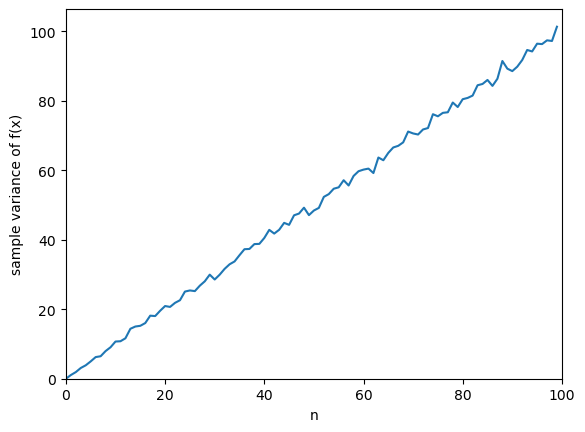

In [4]:
from matplotlib import pyplot as plt

num_n_samples = 100
num_x_samples = 1000
num_f_samples = 100

n_values = list(range(num_n_samples))
var_values = [0.0]
for n in n_values[1:]:
    var_acc = 0.0
    with torch.no_grad():
        for i in range(num_f_samples):
            f = RandomAffineFunction(n)
            x = generate_x(n, (num_x_samples,))
            y = f(x)
            var_acc += float(y.var().item())
    var_values.append(var_acc / num_f_samples)

plt.plot(n_values, var_values)
plt.xlabel("n")
plt.xlim(left=0, right=num_n_samples)
plt.ylabel("sample variance of f(x)")
plt.ylim(bottom=0.0)
plt.show()

As we increase the number of dimensions, the variance of $f(x)$ scales linearly.
Indeed, if we let $f$ (thus $\beta$) and $x$ be random variables, we will see that the variance of $f(x)$ is

$$
\mathrm{Var}\!\left( f(x) \right) = \mathrm{Var}\!\left( \sum_{i=1}^n \beta_i x_i \right) = \sum_{i=1}^n \mathrm{Var}\!\left( \beta_i x_i \right)
$$
where $\beta_i x_i$ is the product of two independent standard normal variables, which is [well-known to have a variance of $1$](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables#Independent_central-normal_distributions).
Thus,
$$
\mathrm{Var}\!\left( f(x) \right) = \sum_{i=1}^n 1 = n
$$

So, if we use this innocent-looking process to generate data of the form $(x, f(x))$, the distribution would change as we vary $n$.
This is probably not desirable!
For example, suppose $f$ were the linear transformation ahead of a sigmoid activation function:

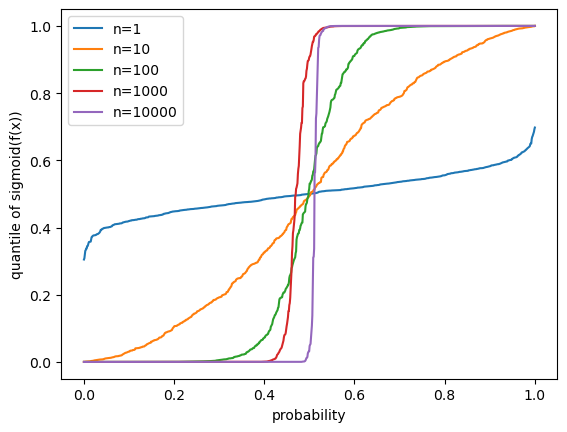

In [5]:
p = torch.linspace(start=0.0, end=1.0, steps=num_x_samples)
with torch.no_grad():
    for n in (1, 10, 100, 1000, 10000):
        f = RandomAffineFunction(n)
        x = generate_x(n, (num_x_samples,))
        y = f(x).sigmoid()
        q = y.sort().values
        plt.plot(p, q.cpu(), label=f"n={n}")

plt.xlabel("probability")
plt.ylabel("quantile of sigmoid(f(x))")
plt.legend()
plt.show()

Our activation functions are more likely to saturate.

Our loss functions will be more unstable.

Our toy problems are unfair at higher dimensions.

## A Solution

Consider the following data generation process for a random linear function $f : \mathbb{R}^n \mapsto \mathbb{R}$:

In [6]:
import math

class ScaledRandomAffineFunction:
    def __init__(self, n: int):
        self.beta = torch.randn(n, device=device) / math.sqrt(n)

    def __call__(self, x: Tensor) -> Tensor:
        return (x * self.beta).sum(dim=-1)

We can repeat the same experiments:

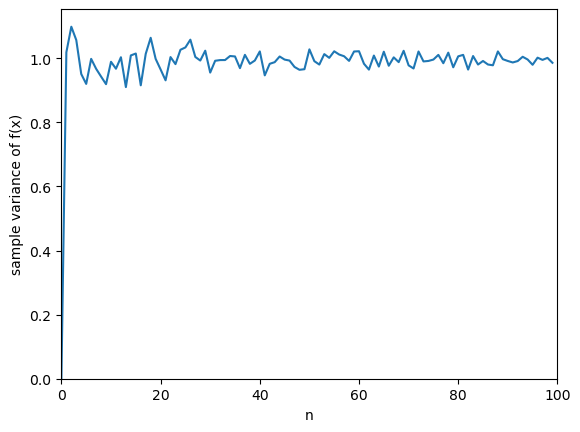

In [7]:
n_values = list(range(num_n_samples))
var_values = [0.0]
for n in n_values[1:]:
    var_acc = 0.0
    with torch.no_grad():
        for i in range(num_f_samples):
            f = ScaledRandomAffineFunction(n)
            x = generate_x(n, (num_x_samples,))
            y = f(x)
            var_acc += float(y.var().item())
    var_values.append(var_acc / num_f_samples)

plt.plot(n_values, var_values)
plt.xlabel("n")
plt.xlim(left=0, right=num_n_samples)
plt.ylabel("sample variance of f(x)")
plt.ylim(bottom=0.0)
plt.show()

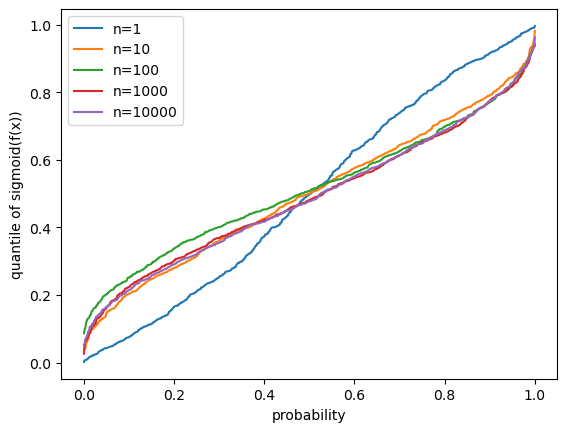

In [8]:
p = torch.linspace(start=0.0, end=1.0, steps=num_x_samples)
with torch.no_grad():
    for n in (1, 10, 100, 1000, 10000):
        f = ScaledRandomAffineFunction(n)
        x = generate_x(n, (num_x_samples,))
        y = f(x).sigmoid()
        q = y.sort().values
        plt.plot(p, q.cpu(), label=f"n={n}")

plt.xlabel("probability")
plt.ylabel("quantile of sigmoid(f(x))")
plt.legend()
plt.show()

Much better!